# Description

This notebook generates the different panels in Figure 7, which summarizes the results of the SI evaluation at the single-scan level.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
import xarray as xr
import os.path as osp
from statannotations.Annotator import Annotator

from utils.basics import PNAS2015_subject_list, PRJ_DIR
from pylab import subplot

***
# 1. Load SI at the single-subject level

In [2]:
si = {}
si['LE']   = pd.read_pickle(osp.join(PRJ_DIR,'Dashboard','Data','si_LE.pkl')).loc[PNAS2015_subject_list,:,:,:,:,[2,3]]
si['TSNE'] = pd.read_pickle(osp.join(PRJ_DIR,'Dashboard','Data','si_TSNE.pkl')).loc[PNAS2015_subject_list,:,:,:,:,[2,3]]
si['UMAP'] = pd.read_pickle(osp.join(PRJ_DIR,'Dashboard','Data','si_UMAP.pkl')).loc[PNAS2015_subject_list,:,:,:,:,:,:,:,[2,3]]

## 1.1 "Beautify" strings/labels for plot generation

The next cell will change some labels to ensure all plots are consistent in terms of naming and that manuscript-ready labels are being used. This does not alter the values in any other way.

In [3]:
for tech in ['LE','TSNE','UMAP']:
    index_names = list(si[tech].index.names)
    index_names = [name if name != 'Input Data' else 'Input' for name in index_names]
    index_names = [name if name != 'Metric'     else 'Distance' for name in index_names]
    index_names = [name if name != 'Norm'       else 'Normalization' for name in index_names]
    
    si[tech].reset_index(inplace=True)
    si[tech].rename(columns={"Metric":"Distance","Input Data":"Input","Norm":"Normalization"},inplace=True)
    
    si[tech].replace('asis','None', inplace=True)
    si[tech].replace('zscored','Z-score', inplace=True)
    si[tech].replace('correlation','Correlation', inplace=True)
    si[tech].replace('euclidean','Euclidean', inplace=True)
    si[tech].replace('cosine','Cosine', inplace=True)
    si[tech].replace('Null_ConnRand','Conn. Rand.', inplace=True)
    si[tech].replace('Null_PhaseRand','Phase Rand.', inplace=True)
    si[tech].drop('Target',axis=1,inplace=True)
    index_names.remove('Target')
    si[tech].set_index(index_names, inplace=True)

Print out how many entries are available. This helps double-check that dataframes contain all expected SI values

In [4]:
print('LE:   ' , [(name,len(si['LE'].index.get_level_values(name).unique())) for name in si['LE'].index.names])
print('TSNE: ' , [(name,len(si['TSNE'].index.get_level_values(name).unique())) for name in si['TSNE'].index.names])
print('UMAP: ' , [(name,len(si['UMAP'].index.get_level_values(name).unique())) for name in si['UMAP'].index.names])

LE:    [('Subject', 20), ('Input', 3), ('Normalization', 2), ('Distance', 3), ('Knn', 40), ('m', 2)]
TSNE:  [('Subject', 20), ('Input', 3), ('Normalization', 2), ('Distance', 3), ('PP', 21), ('m', 2), ('Alpha', 7), ('Init', 1)]
UMAP:  [('Subject', 20), ('Input', 3), ('Normalization', 2), ('Init', 1), ('MinDist', 1), ('Distance', 3), ('Knn', 40), ('Alpha', 3), ('m', 2)]


***
# 2. Plot distributions for LE | Single-Scan Results

(-0.2, 0.8)

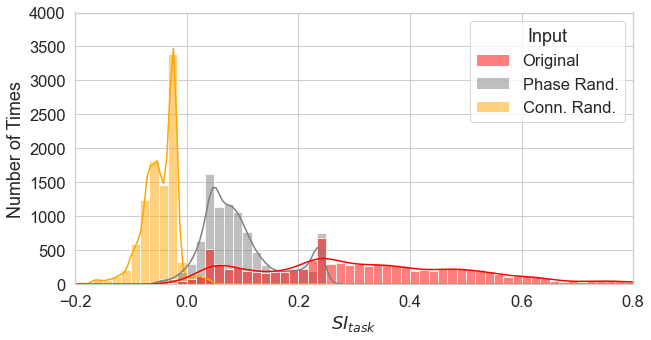

In [5]:
sns.set(font_scale=1.5, style='whitegrid')
fig,axs=plt.subplots(1,1,figsize=(10,5))
sns.histplot(data=si['LE'].reset_index(), x='SI',hue='Input', hue_order=['Original','Phase Rand.','Conn. Rand.'], palette=['Red','Gray','Orange'], kde=True, ax=axs)
axs.set_ylim(0,4000);
axs.set_ylabel('Number of Times');
axs.set_xlabel('$SI_{task}$')
axs.set_xlim(-.2,.8)

Also plot how $SI_{task}$ changes with $K_{nn}$ for the different metrics

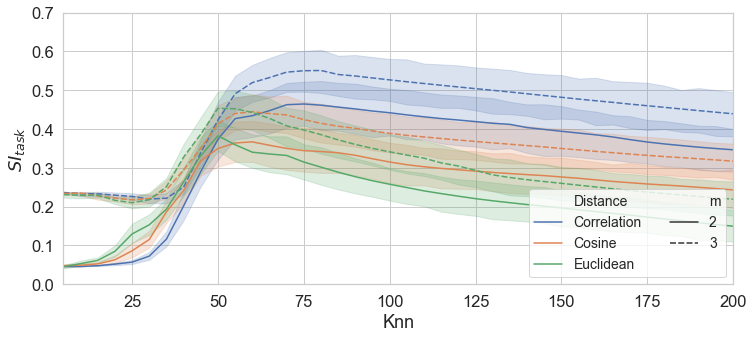

In [6]:
sns.set(font_scale=1.5, style='whitegrid')
fig,ax=plt.subplots(1,1,figsize=(12,5))
sns.lineplot(data=si['LE'].loc[:,'Original',:,:,:,[2,3]],y='SI',x='Knn', hue='Distance', style='m', ax=ax)
ax.set_ylabel('$SI_{task}$')
ax.set_xlim(5,200)
ax.set_ylim(0,.70)
ax.legend(loc='lower right', ncol=2, fontsize=14)

Finally generate a plot that summarize the effects of the normalization step

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Cosine_None vs. Cosine_Z-score: t-test paired samples with Bonferroni correction, P_val:9.276e-03 t=3.155e+00
Correlation_None vs. Correlation_Z-score: t-test paired samples with Bonferroni correction, P_val:1.000e+00 t=-6.140e-01
Euclidean_None vs. Euclidean_Z-score: t-test paired samples with Bonferroni correction, P_val:1.618e-04 t=4.533e+00


(0.0, 0.7)

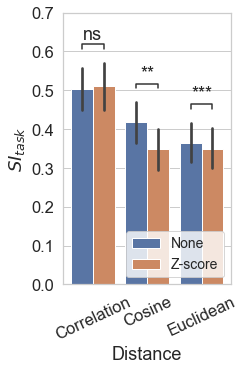

In [7]:
fig,ax         = plt.subplots(1,1,figsize=(3,5))
this_plot_data = si['LE'].loc[:,'Original',:,:,75,[2,3]].reset_index()
plot           = sns.barplot(data=this_plot_data, y='SI', hue='Normalization', x='Distance')
ax.legend(loc='lower right', ncol=1, fontsize=14)
ax.set_ylabel('$SI_{task}$')
plt.xticks(rotation = 25) 

#pairs = [(('None','Correlation'),('Z-score','Correlation')),(('None','Cosine'),('Z-score','Cosine')),(('None','Euclidean'),('Z-score','Euclidean'))]
pairs = [(('Correlation','None'),('Correlation','Z-score')),(('Cosine','None'),('Cosine','Z-score')),(('Euclidean','None'),('Euclidean','Z-score'))]

annot = Annotator(plot, pairs, data=this_plot_data, y='SI', hue='Normalization', x='Distance')
annot.configure(test='t-test_paired', verbose=1, comparisons_correction='Bonferroni', text_format="star")
annot.apply_test()
annot.annotate()
ax.set_ylim(0,.70)

***
# 3. Plot distributions for T-SNE | Single-scan Results

(-0.2, 0.8)

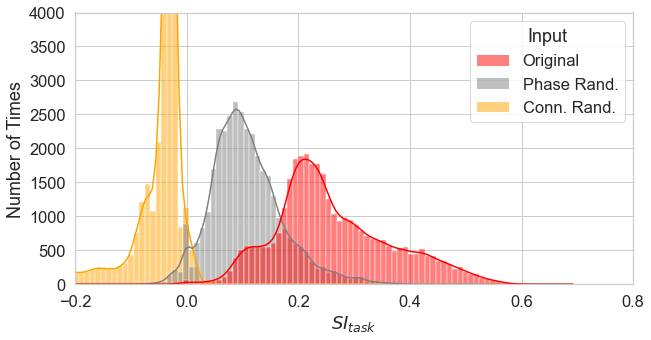

In [8]:
sns.set(font_scale=1.5, style='whitegrid')
fig,axs=plt.subplots(1,1,figsize=(10,5))
sns.histplot(data=si['TSNE'].reset_index(), x='SI',hue='Input', hue_order=['Original','Phase Rand.','Conn. Rand.'], palette=['Red','Gray','Orange'], kde=True, ax=axs)
axs.set_ylim(0,4000);
axs.set_ylabel('Number of Times');
axs.set_xlabel('$SI_{task}$')
axs.set_xlim(-.2,.8)

Also plot how $SI_{task}$ changes with $K_{nn}$ for the different metrics

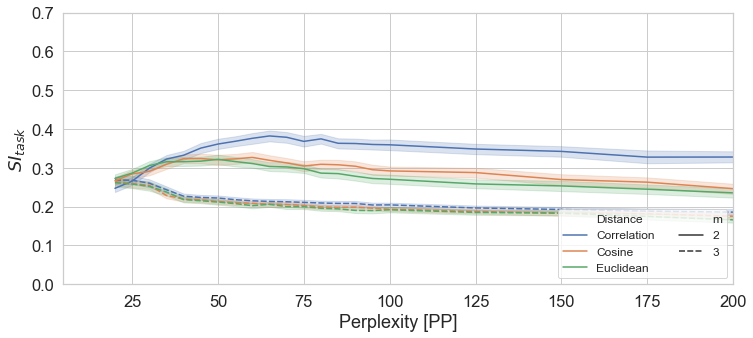

In [9]:
fig,ax=plt.subplots(1,1,figsize=(12,5))
ax =sns.lineplot(data=si['TSNE'].loc[:,'Original',:,:,:,:,:],y='SI',x='PP', hue='Distance', style='m')
ax.set_ylabel('$SI_{task}$')
ax.set_xlabel('Perplexity [PP]')
ax.set_xlim(5,200)
ax.set_ylim(0,.70)
ax.legend(loc='lower right', ncol=2, fontsize=12)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Cosine_None vs. Cosine_Z-score: t-test paired samples with Bonferroni correction, P_val:1.265e-04 t=4.161e+00
Correlation_None vs. Correlation_Z-score: t-test paired samples with Bonferroni correction, P_val:2.374e-02 t=2.675e+00
Euclidean_None vs. Euclidean_Z-score: t-test paired samples with Bonferroni correction, P_val:6.815e-02 t=2.291e+00


(0.0, 0.7)

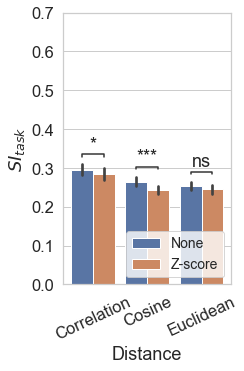

In [10]:
fig,ax         = plt.subplots(1,1,figsize=(3,5))
this_plot_data = si['TSNE'].loc[:,'Original',:,:,75,[2,3],:].reset_index()
plot           = sns.barplot(data=this_plot_data, y='SI',x='Distance', hue='Normalization')
ax.legend(loc='lower right', ncol=1, fontsize=14)
ax.set_ylabel('$SI_{task}$')
plt.xticks(rotation = 25) 
pairs = [(('None','Correlation'),('Z-score','Correlation')),(('None','Cosine'),('Z-score','Cosine')),(('None','Euclidean'),('Z-score','Euclidean'))]
pairs = [(('Correlation','None'),('Correlation','Z-score')),(('Cosine','None'),('Cosine','Z-score')),(('Euclidean','None'),('Euclidean','Z-score'))]

annot = Annotator(plot, pairs, data=this_plot_data, y='SI',x='Distance', hue='Normalization')
annot.configure(test='t-test_paired', verbose=1, comparisons_correction='Bonferroni', text_format="star")
annot.apply_test()
annot.annotate()
ax.set_ylim(0,.70)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10 vs. 50: t-test paired samples with Bonferroni correction, P_val:1.000e+00 t=5.250e-01
10 vs. 75: t-test paired samples with Bonferroni correction, P_val:1.000e+00 t=1.336e+00
10 vs. 100: t-test paired samples with Bonferroni correction, P_val:1.000e+00 t=5.724e-01
10 vs. 200: t-test paired samples with Bonferroni correction, P_val:1.000e+00 t=9.581e-01
10 vs. 500: t-test paired samples with Bonferroni correction, P_val:3.557e-02 t=2.828e+00
10 vs. 1000: t-test paired samples with Bonferroni correction, P_val:2.878e-02 t=2.902e+00


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, '10'),
  Text(1, 0, '50'),
  Text(2, 0, '75'),
  Text(3, 0, '100'),
  Text(4, 0, '200'),
  Text(5, 0, '500'),
  Text(6, 0, '1000')])

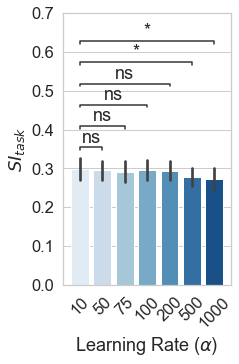

In [11]:
fig,ax         = plt.subplots(1,1,figsize=(3,5))
this_plot_data          = si['TSNE'].loc[:,'Original',:,'Correlation',75,[2,3],:].reset_index().copy()
this_plot_data['Alpha'] = this_plot_data['Alpha'].astype(str)
plot           = sns.barplot(data=this_plot_data, y='SI',x='Alpha', palette='Blues')
#ax.legend(loc='lower right', ncol=1, fontsize=14)
ax.set_ylabel('$SI_{task}$')
ax.set_xlabel(r'Learning Rate ($\alpha$)')
pairs = [("10","50"),("10","75"),("10","100"),("10","200"),("10","500"),("10","1000")]
annot = Annotator(plot, pairs, data=this_plot_data, y='SI',x='Alpha')
annot.configure(test='t-test_paired', verbose=1, comparisons_correction='Bonferroni', text_format="star")
annot.apply_test()
annot.annotate()
ax.set_ylim(0,.70)
plt.xticks(rotation = 45) 

# UMAP | Single-scan Results

(-0.2, 0.8)

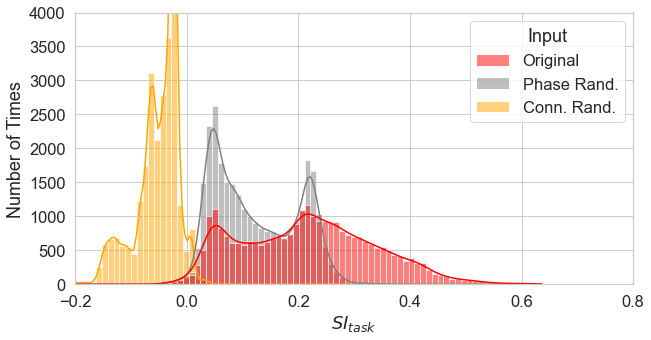

In [13]:
sns.set(font_scale=1.5, style='whitegrid')
fig,axs=plt.subplots(1,1,figsize=(10,5))
sns.histplot(data=si['UMAP'].reset_index(), x='SI',hue='Input', hue_order=['Original','Phase Rand.','Conn. Rand.'], palette=['Red','Gray','Orange'], kde=True, ax=axs)
axs.set_ylim(0,4000);
axs.set_ylabel('Number of Times');
axs.set_xlabel('$SI_{task}$')
axs.set_xlim(-.2,.8)

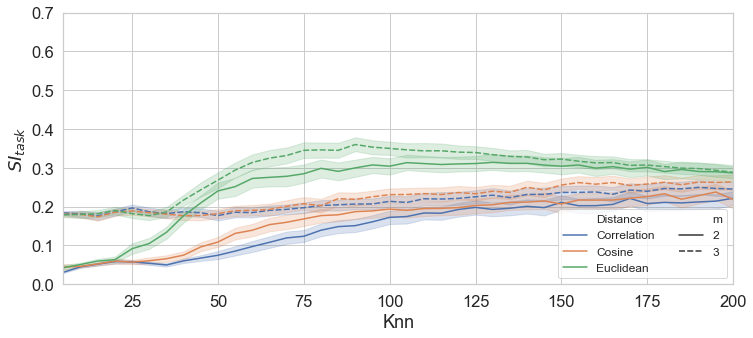

In [14]:
fig,ax=plt.subplots(1,1,figsize=(12,5))
ax =sns.lineplot(data=si['UMAP'].loc[:,'Original',:,:,:,:,:,:,:,:],y='SI',x='Knn', hue='Distance', style='m')
ax.set_ylabel('$SI_{task}$')
ax.set_xlim(5,200)
ax.set_ylim(0,.7)
ax.legend(loc='lower right', ncol=2, fontsize=12)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Cosine_None vs. Cosine_Z-score: t-test paired samples with Bonferroni correction, P_val:1.000e+00 t=2.874e-01
Correlation_None vs. Correlation_Z-score: t-test paired samples with Bonferroni correction, P_val:3.698e-01 t=1.552e+00
Euclidean_None vs. Euclidean_Z-score: t-test paired samples with Bonferroni correction, P_val:1.000e+00 t=3.201e-01


(0.0, 0.7)

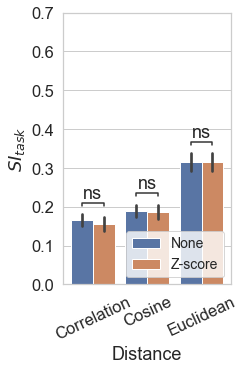

In [15]:
fig,ax         = plt.subplots(1,1,figsize=(3,5))
this_plot_data = si['UMAP'].loc[:,'Original',:,:,:,:,75,:,[2,3],:].reset_index()
plot           = sns.barplot(data=this_plot_data, y='SI',x='Distance', hue='Normalization')
ax.legend(loc='lower right', ncol=1, fontsize=14)
ax.set_ylabel('$SI_{task}$')
plt.xticks(rotation = 25) 
pairs = [(('None','Correlation'),('Z-score','Correlation')),(('None','Cosine'),('Z-score','Cosine')),(('None','Euclidean'),('Z-score','Euclidean'))]
pairs = [(('Correlation','None'),('Correlation','Z-score')),(('Cosine','None'),('Cosine','Z-score')),(('Euclidean','None'),('Euclidean','Z-score'))]

annot = Annotator(plot, pairs, data=this_plot_data, y='SI',x='Distance', hue='Normalization')
annot.configure(test='t-test_paired', verbose=1, comparisons_correction='Bonferroni', text_format="star")
annot.apply_test()
annot.annotate()
ax.set_ylim(0,.70)

***
## Scan Selection for Figure 8

In [16]:
si['LE'].loc[:,'Original',:,'Correlation',75,2].sort_values(by='SI', ascending=False).head(1)

,,,,,,SI
Subject,Input,Normalization,Distance,Knn,m,
SBJ06,Original,Z-score,Correlation,75,2,0.784729


In [17]:
si['LE'].loc[:,'Original',:,'Correlation',75,2].sort_values(by='SI', ascending=True).head(1)

,,,,,,SI
Subject,Input,Normalization,Distance,Knn,m,
SBJ21,Original,Z-score,Correlation,75,2,0.00886
